<a href="https://colab.research.google.com/github/sidharthworks/chat/blob/master/CIFAR_10_SP%2BML_Unlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi
!pip install torch torchvision matplotlib scikit-learn


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os, pickle, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns


In [ ]:
# Download CIFAR-10 from Toronto site
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!ls cifar-10-batches-py


--2025-09-06 04:50:23--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  15.9MB/s    in 11s     

2025-09-06 04:50:35 (14.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [ ]:
root = "/content/cifar-10-batches-py"

class CIFAR10Pickle(Dataset):
    def __init__(self, root, train=True, poison_mode=None, poison_rate=0.0,
                 flip_from=2, flip_to=7):
        self.train = train
        self.data, self.labels = [], []
        files = [f"data_batch_{i}" for i in range(1,6)] if train else ["test_batch"]

        for f in files:
            with open(os.path.join(root, f), 'rb') as fo:
                d = pickle.load(fo, encoding='bytes')
            self.data.append(d[b'data'])
            self.labels.extend(d[b'labels'])
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32).astype("uint8")
        self.labels = np.array(self.labels)

        self.poisoned_idx = []
        if poison_mode == "labelflip":
            n_poison = int(len(self.labels) * poison_rate)
            candidates = np.where(self.labels == flip_from)[0]
            selected = np.random.choice(candidates, n_poison, replace=False)
            self.labels[selected] = flip_to
            self.poisoned_idx = selected.tolist()

    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        x = self.data[idx].astype(np.float32) / 255.0
        y = self.labels[idx]
        return torch.tensor(x), y


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*16*16, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
def train_model(model, loader, optimizer, epochs=10, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss {total_loss/len(loader):.4f}")

def evaluate(model, loader, device="cuda"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    return correct/total


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

trainset = CIFAR10Pickle(root, train=True, poison_mode="labelflip", poison_rate=0.05, flip_from=2, flip_to=7)
testset = CIFAR10Pickle(root, train=False)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

print(f"Training set size: {len(trainset)}")
print(f"Poisoned samples: {len(trainset.poisoned_idx)}")
print(f"Test set size: {len(testset)}")


Training set size: 50000
Poisoned samples: 2500
Test set size: 10000


In [ ]:
model = SimpleCNN()
opt = optim.Adam(model.parameters(), lr=1e-3)

print("Training poisoned model...")
train_model(model, trainloader, opt, epochs=10, device=device)

acc = evaluate(model, testloader, device)
print(f"Test accuracy before mitigation: {acc:.4f}")


Training poisoned model...
Epoch 1, Loss 1.5488
Epoch 2, Loss 1.1085
Epoch 3, Loss 0.9314
Epoch 4, Loss 0.7926
Epoch 5, Loss 0.6722
Epoch 6, Loss 0.5622
Epoch 7, Loss 0.4493
Epoch 8, Loss 0.3445
Epoch 9, Loss 0.2495
Epoch 10, Loss 0.1835
Test accuracy before mitigation: 0.6574


In [ ]:
def detect_poisoned_SPF(model, loader, device="cuda", frac=0.1):
    """
    SPF = Statistical Perturbation Filtering
    Combines per-sample loss & entropy to flag anomalous samples.
    """
    model.eval()
    scores, all_idx = [], []
    criterion = nn.CrossEntropyLoss(reduction='none')

    with torch.no_grad():
        for batch_idx, (x,y) in enumerate(loader):
            x,y = x.to(device), y.to(device)
            out = model(x)

            # per-sample loss
            losses = criterion(out, y).cpu().numpy()

            # entropy of predictions
            probs = F.softmax(out,1).cpu().numpy()
            entropy = -np.sum(probs * np.log(probs+1e-8), axis=1)

            # combined anomaly score
            batch_scores = losses + 0.5 * entropy
            scores.extend(batch_scores.tolist())

            # dataset indices
            start = batch_idx * loader.batch_size
            all_idx.extend(range(start, start+len(y)))

    scores = np.array(scores)
    k = int(len(scores) * frac)
    flagged = scores.argsort()[-k:]
    return flagged

print("Running Phase 1 SPF detection...")
flagged = detect_poisoned_SPF(model, trainloader, device, frac=0.1)
print(f"Flagged {len(flagged)} suspicious samples")


Running Phase 1 SPF detection...
Flagged 5000 suspicious samples


In [ ]:
def unlearn_balanced(model, trainloader, flagged_idx, lr=1e-4, steps=1000, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = trainloader.dataset
    flagged_set = torch.utils.data.Subset(dataset, flagged_idx)
    clean_idx = list(set(range(len(dataset))) - set(flagged_idx))
    clean_set = torch.utils.data.Subset(dataset, clean_idx)

    flagged_loader = DataLoader(flagged_set, batch_size=64, shuffle=True)
    clean_loader = DataLoader(clean_set, batch_size=64, shuffle=True)

    flagged_iter, clean_iter = iter(flagged_loader), iter(clean_loader)
    model.to(device)

    for step in range(steps):
        # Forget flagged
        try: x,y = next(flagged_iter)
        except StopIteration: flagged_iter = iter(flagged_loader); x,y = next(flagged_iter)
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = -(0.05 * criterion(model(x), y))
        loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Stabilize with clean
        try: x,y = next(clean_iter)
        except StopIteration: clean_iter = iter(clean_loader); x,y = next(clean_iter)
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        if step % 200 == 0:
            print(f"Step {step}, Loss {loss.item():.4f}")


In [ ]:
print("Running Phase 2 balanced unlearning...")
unlearn_balanced(model, trainloader, flagged, lr=1e-4, steps=1000, device=device)

acc_after = evaluate(model, testloader, device)
print(f"Test accuracy after mitigation: {acc_after:.4f}")


Running Phase 2 balanced unlearning...
Step 0, Loss 0.2354
Step 200, Loss 0.0946
Step 400, Loss 0.0766
Step 600, Loss 0.0698
Step 800, Loss 0.0490
Test accuracy after mitigation: 0.6566


In [ ]:
def per_class_accuracy(model, loader, device="cuda"):
    model.eval()
    correct = {i:0 for i in range(10)}
    total = {i:0 for i in range(10)}
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            for i in range(len(y)):
                total[y[i].item()] += 1
                if preds[i]==y[i]:
                    correct[y[i].item()] += 1
    return {cls: correct[cls]/total[cls] for cls in range(10)}

before_accs = per_class_accuracy(model, testloader, device)
print("Per-class accuracy after mitigation:", before_accs)


Per-class accuracy after mitigation: {0: 0.75, 1: 0.781, 2: 0.239, 3: 0.478, 4: 0.605, 5: 0.589, 6: 0.758, 7: 0.788, 8: 0.792, 9: 0.786}


Epoch 1, Loss 1.4532
Epoch 2, Loss 1.0747
Epoch 3, Loss 0.8936
Epoch 4, Loss 0.7551
Epoch 5, Loss 0.6275
Epoch 6, Loss 0.5006
Epoch 7, Loss 0.3776
Epoch 8, Loss 0.2637
Epoch 9, Loss 0.1847
Epoch 10, Loss 0.1200


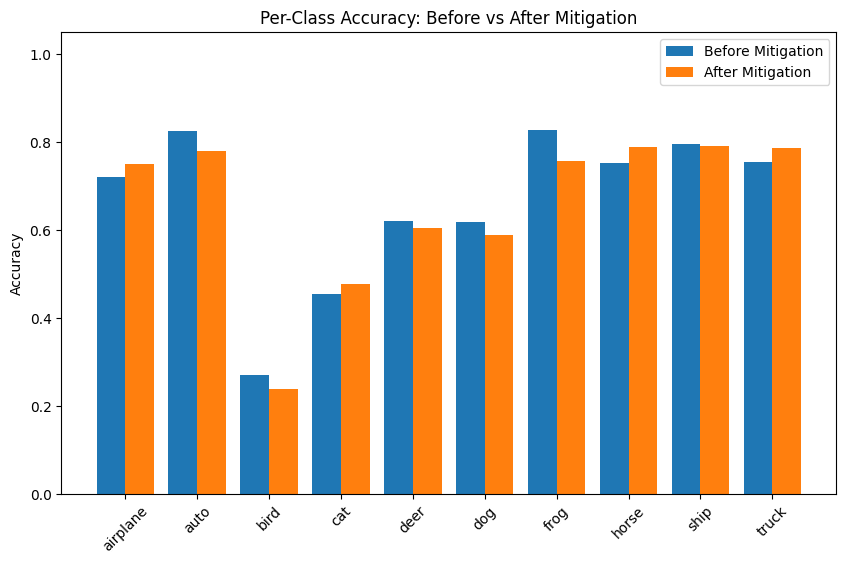

In [ ]:
# Evaluate BEFORE mitigation (using the poisoned model before unlearning)
poisoned_model = SimpleCNN().to(device)
opt = optim.Adam(poisoned_model.parameters(), lr=1e-3)
train_model(poisoned_model, trainloader, opt, epochs=10, device=device)
before_acc = per_class_accuracy(poisoned_model, testloader, device)

# Evaluate AFTER mitigation (using your healed model)
after_acc = per_class_accuracy(model, testloader, device)

# Plot
classes = ["airplane","auto","bird","cat","deer","dog","frog","horse","ship","truck"]
x = np.arange(len(classes))

plt.figure(figsize=(10,6))
plt.bar(x-0.2, list(before_acc.values()), width=0.4, label="Before Mitigation")
plt.bar(x+0.2, list(after_acc.values()), width=0.4, label="After Mitigation")
plt.xticks(x, classes, rotation=45)
plt.ylabel("Accuracy")
plt.ylim(0,1.05)
plt.title("Per-Class Accuracy: Before vs After Mitigation")
plt.legend()
plt.show()
